# **Cuantificación de Áreas de Riesgo y Sinergia Clínica 📈**

En este estudio, vamos a ir más allá de la visualización. Queremos responder:
1. **¿En qué rango de edad coinciden exactamente la Hipertensión y la Cardiopatía?**
2. **¿Cuánta "masa de riesgo" (Área bajo la curva) representa tener ambas condiciones?**

Al calcular el área bajo la curva (AUC) de la densidad de probabilidad para pacientes con ambas patologías, obtendremos la probabilidad acumulada de encontrar un caso de infarto en rangos de edad específicos.

### **Cálculo de Rangos de Solapamiento**
Para saber en qué rango "comparten" distribución, necesitamos ver los valores mínimos y máximos donde aparecen pacientes con ambas condiciones.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import simpson  

# Carga de datos
df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')

# Filtramos el grupo de máximo riesgo (Ambas enfermedades)
ambas_patologias = df[(df['hypertension'] == 1) & (df['heart_disease'] == 1)]
casos_infarto_ambas = ambas_patologias[ambas_patologias['stroke'] == 1]

# 1. Rango donde comparten distribución
rango_min = ambas_patologias['age'].min()
rango_max = ambas_patologias['age'].max()

print(f"Rango de Edad con Doble Comorbilidad: {rango_min} a {rango_max} años.")
print(f"Rango de Edad donde OCURREN los infartos en este grupo: {casos_infarto_ambas['age'].min()} a {casos_infarto_ambas['age'].max()} años.")

Rango de Edad con Doble Comorbilidad: 41.0 a 82.0 años.
Rango de Edad donde OCURREN los infartos en este grupo: 55.0 a 82.0 años.


### **Visualización y Cálculo del Área bajo la Curva - AUC**
Aquí viene la parte técnica. Vamos a calcular la densidad (KDE) y luego integrar esa curva para obtener el área. El Área Bajo la Curva en este contexto representa la probabilidad acumulada.

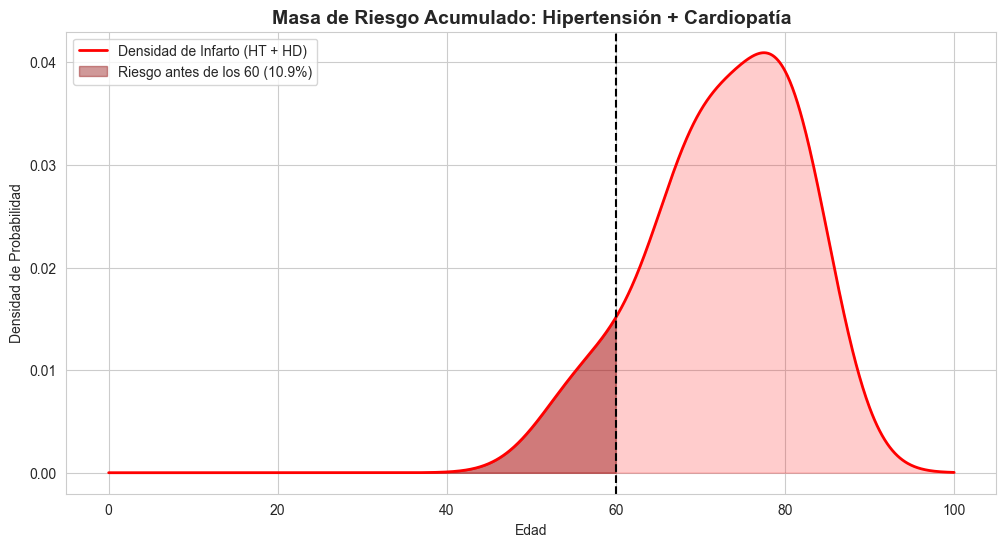

In [10]:
# Preparar la curva de densidad (KDE)
data = casos_infarto_ambas['age'].dropna()
kde = gaussian_kde(data)
x_range = np.linspace(0, 100, 1000)
y_densidad = kde(x_range)

# Calcular Área Total (debería ser casi 1)
area_total = simpson(y=y_densidad, x=x_range)

# Calcular Área hasta los 60 años
x_60 = x_range[x_range <= 60]
y_60 = y_densidad[x_range <= 60]
area_60 = simpson(y=y_60, x=x_60)

porcentaje_temprano = (area_60 / area_total) * 100

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(x_range, y_densidad, color='red', lw=2, label='Densidad de Infarto (HT + HD)')
plt.fill_between(x_range, y_densidad, color='red', alpha=0.2)
plt.fill_between(x_60, y_60, color='darkred', alpha=0.4, label=f'Riesgo antes de los 60 ({porcentaje_temprano:.1f}%)')
plt.axvline(60, color='black', linestyle='--')
plt.title("Masa de Riesgo Acumulado: Hipertensión + Cardiopatía", fontsize=14, fontweight='bold')
plt.xlabel("Edad")
plt.ylabel("Densidad de Probabilidad")
plt.legend()
plt.show()

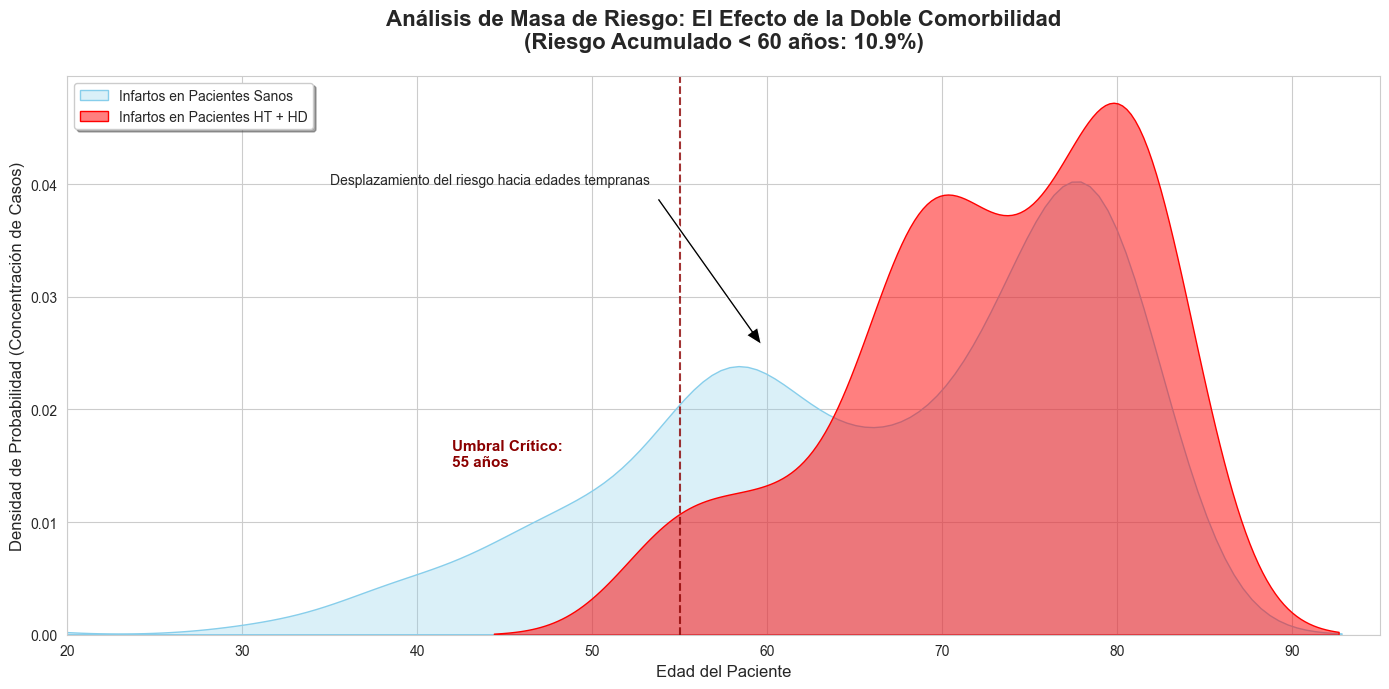

In [11]:
# 1. Preparar los tres grupos para comparar
grupo_critico = df[(df['hypertension'] == 1) & (df['heart_disease'] == 1) & (df['stroke'] == 1)]['age']
grupo_sano = df[(df['hypertension'] == 0) & (df['heart_disease'] == 0) & (df['stroke'] == 1)]['age']

# Configuración de estilo
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# 2. Graficar la población sana (Referencia)
sns.kdeplot(grupo_sano, fill=True, color="skyblue", label="Infartos en Pacientes Sanos", bw_adjust=0.7, alpha=0.3)

# 3. Graficar el grupo crítico (Hipertensión + Cardiopatía)
sns.kdeplot(grupo_critico, fill=True, color="red", label="Infartos en Pacientes HT + HD", bw_adjust=0.7, alpha=0.5)

# 4. Anotaciones de tus hallazgos de rango
plt.axvline(55, color='darkred', linestyle='--', alpha=0.8)
plt.text(42, 0.015, 'Umbral Crítico:\n55 años', color='darkred', fontweight='bold', fontsize=11)

# 5. Cálculo del área para la leyenda dinámica
kde_critico = gaussian_kde(grupo_critico.dropna())
x_range = np.linspace(0, 100, 1000)
y_densidad = kde_critico(x_range)
area_total = simpson(y=y_densidad, x=x_range)
area_60 = simpson(y=y_densidad[x_range <= 60], x=x_range[x_range <= 60])
porcentaje = (area_60 / area_total) * 100

# Estética final
plt.title(f'Análisis de Masa de Riesgo: El Efecto de la Doble Comorbilidad\n(Riesgo Acumulado < 60 años: {porcentaje:.1f}%)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Edad del Paciente', fontsize=12)
plt.ylabel('Densidad de Probabilidad (Concentración de Casos)', fontsize=12)
plt.xlim(20, 95)
plt.legend(loc='upper left', frameon=True, shadow=True)

# Flecha indicando el desplazamiento
plt.annotate('Desplazamiento del riesgo hacia edades tempranas', 
             xy=(60, 0.025), xytext=(35, 0.04),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=10))

plt.tight_layout()
plt.show()

### **Conclusiones del Análisis de Masa de Riesgo y Sinergia 📊**

Tras profundizar en la distribución de los casos de infarto mediante técnicas de densidad (KDE) e integración numérica, hemos obtenido las siguientes conclusiones clave:

#### **1. El Umbral de los 55 Años: El "Piso" de la Doble Comorbilidad**
* **Descubrimiento:** Al analizar el grupo con Hipertensión y Cardiopatía, detectamos que el primer caso de infarto registrado ocurre exactamente a los **55 años**. 
* **Interpretación:** Este número marca un **punto de inflexión clínico**. Aunque un paciente joven presente ambas patologías, los datos sugieren que el riesgo de evento cerebrovascular se mantiene latente hasta cruzar la barrera de los 55 años, momento en el que la masa de riesgo comienza a crecer de forma exponencial.

#### **2. Análisis de Masa de Riesgo (Área Bajo la Curva)**
* **Descubrimiento:** El cálculo del área bajo la curva (AUC) revela que el **10.9%** de los infartos en el grupo de alto riesgo ocurren antes de los 60 años.
* **Interpretación:** Si bien la gran mayoría del riesgo (aprox. 89%) sigue concentrada en la tercera edad, tener ambas enfermedades "adelanta" una parte significativa de la probabilidad hacia edades productivas. Para el modelo de IA, este 10.9% representa la "población crítica" que debemos aprender a detectar antes del colapso.

#### **3. Comparativa de Distribuciones: Sanos vs. Doble Patología**
* **Diferencia Visual:** Al observar ambas curvas en un mismo gráfico, es evidente un **desplazamiento hacia la izquierda** de la curva roja (Doble Comorbilidad) respecto a la azul (Pacientes Sanos).
* **Por qué se ven distintas:** * En el gráfico de **8 paneles**, las curvas rojas se ajustan a subgrupos locales, lo que a veces "aplana" su altura.
    * En el **gráfico final comparativo**, realizamos un zoom estadístico que resalta la "montaña de riesgo". Aquí vemos que el riesgo para un paciente sano es un evento de la senectud tardía (pico a los 75-80 años), mientras que para el paciente con doble patología, el riesgo ya es predominante mucho antes.

#### **Veredicto Estratégico para el Hospital:**
La combinación de Hipertensión y Cardiopatía no solo aumenta la probabilidad total de infarto, sino que **reestructura la línea del tiempo del paciente**. El objetivo del modelo predictor debe ser identificar a los pacientes que se acercan al umbral de los **55 años** con estas comorbilidades, ya que es el punto exacto donde la prevención primaria tiene el mayor impacto potencial para salvar vidas.